# Foundations 3: Homework for lab on connectivity and graph theory
- Due November 22, 2023
- Instructor: Ruben Sanchez-Romero
- T.A: Jaleesa Longfellow
- Fall 2023 CMBN

Save the notebook *.ipynb file adding your name (eg. HW_ConnGraphTheory_Foundations3_RubenSanchez.ipynb)
and send it to [ruben.saro.at.rutgers.edu]. 
I will run the notebook to grade it.

Important! Be aware that Amarel will be down for maintenance Nov 21 & 22 (https://oarc.rutgers.edu/amarel-system-status/)

In [1]:
# necessary packages for the homework
import numpy as np
import matplotlib.pyplot as plt
import bct as bct
from scipy import stats

### For the homework we will work with empirical Human Connectome Project resting-state data

1. Download the resting-state preprocessed data for the first 20 subjects from the HCP dataset (fMRI lab)

2. Compute the Pearson correlation FC for each subject individually (360 x 360 matrix for each individual)

3. Compute the group average FC (360 x 360 matrix)

In [2]:
fc_group = np.random.normal(0,1,(360,360))

4. Plot the group average FC

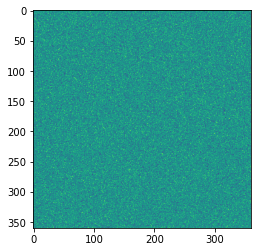

In [3]:
plt.imshow(fc_group)

### We will explore how graph metrics change as the density of the graph changes

5. For mean degree, mean clustering coefficient, characteristic path length and mean betweenness centrality, plot the graph metric (y-axis) versus increasing values of density of the graph (x-axis). Consider densities 5%, 10%, 20% and 40%. Show the 4 plots. One for each graph metric. (As in the lab, only consider positive correlations.)

-density of the thresholded network = 0.05
-density of the thresholded network = 0.10
-density of the thresholded network = 0.20
-density of the thresholded network = 0.40


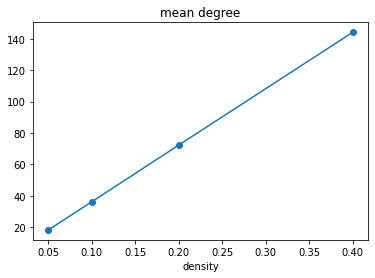

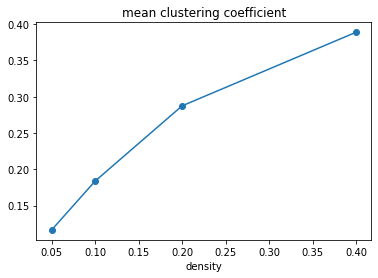

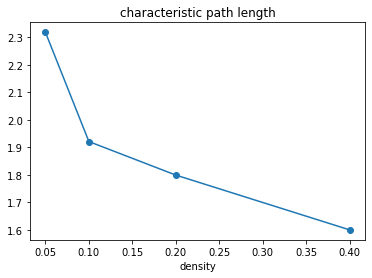

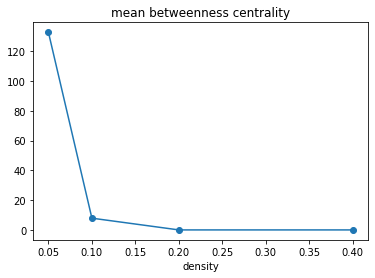

In [4]:

num_nodes = np.shape(fc_group)[0]
num_possible_edges = (num_nodes*(num_nodes-1))/2
ut_idx = np.triu_indices(num_nodes,k=1)
ordered_edges = np.flip(np.sort(fc_group[ut_idx][fc_group[ut_idx]>0]))

# save the results here
mean_degree = []
mean_clusteringCoefficient = []
charPathLength = []
mean_btwCentrality =[]

target_density_array = [0.05,0.10,0.20,0.40]

# loop across density and save the graph metrics results
for target_density in target_density_array :
    # threshold the matrix according to the density
    num_target_edges = int(target_density*num_possible_edges)
    cutoff = ordered_edges[num_target_edges]
    thresh_network = np.multiply(fc_group,(fc_group > cutoff))
    # confirm that the thresholding worked
    density_thresh_network = (np.sum(np.sum(thresh_network!=0))/2)/num_possible_edges
    print(f'-density of the thresholded network = {density_thresh_network:.2f}')
    # compute the graph metrics for the thresh_network
    mean_degree.append(np.mean(bct.degrees_und(thresh_network)))
    mean_clusteringCoefficient.append(np.mean(bct.clustering_coef_bu(thresh_network)))
    charPathLength.append(bct.charpath(bct.distance_bin(thresh_network))[0])
    mean_btwCentrality.append(np.mean(bct.betweenness_bin(thresh_network)))
                                      
# plot the results for each metric individually
plt.figure()
plt.plot(target_density_array,mean_degree,marker='o')
plt.title('mean degree')
plt.xlabel('density')
plt.show()

plt.figure()
plt.plot(target_density_array,mean_clusteringCoefficient,marker='o')
plt.title('mean clustering coefficient')
plt.xlabel('density')
plt.show()

plt.figure()
plt.plot(target_density_array,charPathLength,marker='o')
plt.title('characteristic path length')
plt.xlabel('density')
plt.show()

plt.figure()
plt.plot(target_density_array,mean_btwCentrality,marker='o')
plt.title('mean betweenness centrality')
plt.xlabel('density')
plt.show()

### We will explore if the resting-state FC graph metrics differ from a null model without structure

6. For a density of 10% produce 2000 null models and use those to determine if the resting-state correlation FC graph metrics (mean clustering coefficient, characteristic path length and mean betweenness centrality) are significantly different from a null model without structure. Report the p-values (as computed in the lab).

In [33]:
# threshold the matrix
num_nodes = np.shape(fc_group)[0]
num_possible_edges = (num_nodes*(num_nodes-1))/2
ut_idx = np.triu_indices(num_nodes,k=1)
ordered_edges = np.flip(np.sort(fc_group[ut_idx][fc_group[ut_idx]>0]))
target_density = 0.10
num_target_edges = int(target_density*num_possible_edges)
cutoff = ordered_edges[num_target_edges]
network_th = np.multiply(fc_group,(fc_group > cutoff))
# confirm that the target density was obtained
density_network_th = (np.sum(np.sum(network_th!=0))/2)/num_possible_edges
print(f'-density of the thresholded network = {density_network_th:.2f}')
    

# build the null models using the function from the lab
def null_model_generator(graph):
    n_nodes = np.shape(graph)[0]
    null_model = np.zeros((n_nodes,n_nodes))
    ut_idx = np.triu_indices(n_nodes,k=1)
    edges_vector = graph[ut_idx]
    rand_edges_vector = np.random.choice(edges_vector, size=len(edges_vector), replace=False)
    null_model[ut_idx] = rand_edges_vector
    null_model = (null_model + null_model.T) != 0
    return null_model


# produce N repetitions of the null model
number_permutations = 2000
n_nodes = np.shape(network_th)[0]
null_model_all = np.zeros((n_nodes,n_nodes,number_permutations))
# loop 
for N in range(number_permutations):
    null_model_all[:,:,N] = null_model_generator(network_th)

# compute the metrics for the null models
# allocate space for the results
null_distribution_meanCC = np.zeros((number_permutations,1))
null_distribution_ChPL = np.zeros((number_permutations,1)) 
null_distribution_meanBwC = np.zeros((number_permutations,1))

# compute the metric of interest for each null model
for N in range(number_permutations):
    null_distribution_meanCC[N] = np.mean(bct.clustering_coef_bu(null_model_all[:,:,N]))
    null_distribution_ChPL[N] = bct.charpath(bct.distance_bin(null_model_all[:,:,N]))[0]
    null_distribution_meanBwC[N] = np.mean(bct.betweenness_bin(null_model_all[:,:,N]))


# compute the p-values
# compute the metrics of interest for the target density resting-state FC
meanCC = np.mean(bct.clustering_coef_bu(network_th))
# compute the permutation p-value
pval_meanCC = np.sum(null_distribution_meanCC > meanCC)/number_permutations
print(f'pval for rs-FC {target_density} density graph mean clustering coefficient = {pval_meanCC}')

ChPL = bct.charpath(bct.distance_bin(network_th))[0]
pval_ChPL = np.sum(null_distribution_ChPL > ChPL)/number_permutations
print(f'pval for rs-FC {target_density} density graph characterstic path length = {pval_ChPL}')

meanBwC = np.mean(bct.betweenness_bin(network_th))
# compute the permutation p-value
pval_meanBwC = np.sum(null_distribution_meanBwC > meanBwC)/number_permutations
print(f'pval for rs-FC {target_density} density graph mean clustering coefficient = {pval_meanBwC}')

-density of the thresholded network = 0.10
pval for rs-FC 0.1 density graph mean clustering coefficient = 0.0
pval for rs-FC 0.1 density graph characterstic path length = 1.0
pval for rs-FC 0.1 density graph mean clustering coefficient = 1.0


### Finally, we will determine if the resting-state FC graph metrics differ between different subsets of subjects of the HCP data

7. Repeat questions 1 to 4 but this time using the last 20 subjects from the HCP data

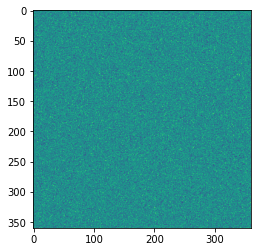

In [30]:
fc_group2 = np.random.normal(0,1,(360,360))
plt.imshow(fc_group2)

8. Threshold the group average FC matrix at 10% density, as above

In [31]:
# threshold the matrix
num_nodes = np.shape(fc_group2)[0]
num_possible_edges = (num_nodes*(num_nodes-1))/2
ut_idx = np.triu_indices(num_nodes,k=1)
ordered_edges = np.flip(np.sort(fc_group2[ut_idx][fc_group2[ut_idx]>0]))
target_density = 0.10
num_target_edges = int(target_density*num_possible_edges)
cutoff = ordered_edges[num_target_edges]
network_th2 = np.multiply(fc_group2,(fc_group2 > cutoff))
# confirm that the target density was obtained
density_network_th2 = (np.sum(np.sum(network_th2!=0))/2)/num_possible_edges
print(f'-density of the thresholded network for group 2 = {density_network_th2:.2f}')

-density of the thresholded network for group 2 = 0.10


9. Using the Wilcoxon signed-rank test determine if the first group FC graph metrics differ from the last group FC graph metrics. Consider both FCs at 10% density. Do the comparison for clustering coefficient, shortest path length (not characteristic path length) and betweenness centrality. Report the result of the Wilcoxon function and describe if the pvalue indicates that the difference is significant or not. 

In [37]:
# group 1 metrics
# we can use network_th defined above
# clustering coefficient (defined for each node)
g1_clusteringCoefficient = bct.clustering_coef_bu(network_th)
# shortest path length (defined for each pair of nodes, just take the upper triangular)
num_nodes = np.shape(network_th)[0]
ut_idx = np.triu_indices(num_nodes,k=1)
g1_shortestPathLength = bct.distance_bin(network_th)[ut_idx]
# betweenness centrality (defined for each node)
g1_btwCentrality = bct.betweenness_bin(network_th)

# do it again for the second group
g2_clusteringCoefficient = bct.clustering_coef_bu(network_th2)
num_nodes = np.shape(network_th2)[0]
ut_idx = np.triu_indices(num_nodes,k=1)
g2_shortestPathLength = bct.distance_bin(network_th2)[ut_idx]
g2_btwCentrality = bct.betweenness_bin(network_th2)

# compute the Wilcoxon signed-rank test
print('Wilcoxon test for clustering coefficient')
difference = g1_clusteringCoefficient - g2_clusteringCoefficient
wilcoxon_test = stats.wilcoxon(difference, alternative='two-sided')
print(wilcoxon_test)
print('')

print('Wilcoxon test for shortest path length')
difference = g1_shortestPathLength - g2_shortestPathLength
wilcoxon_test = stats.wilcoxon(difference, alternative='two-sided')
print(wilcoxon_test)
print('')

print('Wilcoxon test for betweenness centrality')
difference = g1_btwCentrality - g2_btwCentrality
wilcoxon_test = stats.wilcoxon(difference, alternative='two-sided')
print(wilcoxon_test)
print('')

Wilcoxon test for clustering coefficient
WilcoxonResult(statistic=31564.0, pvalue=0.6393233013348445)

Wilcoxon test for shortest path length
WilcoxonResult(statistic=50045373.5, pvalue=0.274713978424052)

Wilcoxon test for betweenness centrality
WilcoxonResult(statistic=19706.0, pvalue=9.804526190313043e-11)

